## Multiple synthetic seismic models with vertical fault

I took [Agile Scientific](https://agilescientific.com/)'s [x lines of code, Wedge model](https://github.com/agile-geoscience/xlines/blob/master/notebooks/00_Synthetic_wedge_model.ipynb) and adapt it to make 100 synthetic models: 10 impedance models x 10 wavelets x 10 random noise fields + 1 fault. **N.B. code is optimized for Python 3.7.1**

#### preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.ndimage as snd
import copy
import bruges

#### make an initial layered model

In [2]:
model = np.zeros((50,49), dtype=np.int) 
model[8:16,:]=1
model[16:24,:]=2
model[24:32,:]=3
model[32:40,:]=4
model[40:,:]=5

(50, 49)


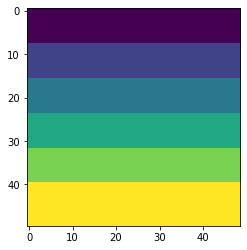

In [3]:
plt.imshow(model, cmap='viridis', aspect=1);
print (np.shape(model))

#### make some Vp-rho pairs (rock 0, rock 1, ... , rock5)

In [4]:
rocks = np.array([[2700, 2750],  # Vp, rho
                  [2400, 2450],
                  [2600, 2650], 
                  [2400, 2450],
                  [2800, 3000], 
                  [3100, 3200],])

#### create 10 slightly different variations of the Vp-rho pairs in the next tow cells

In [5]:
r = np.random.RandomState(1234)
rnd = r.rand(10,6,2)*0.2
print (np.shape(rnd))


(10, 6, 2)


In [6]:
mrocks = np.array([rocks + rocks*rn for rn in rnd], dtype=np.int)
manyrocks = np.rollaxis(mrocks,1,0)
print (np.shape(manyrocks))

(6, 10, 2)


####  create 10 earth models by combining Vp-rho pairs with the layered model, dispaly a pair

In [7]:
earth = manyrocks[model]
earth = np.rollaxis(earth,2,0)
print (np.shape(earth))

(10, 50, 49, 2)


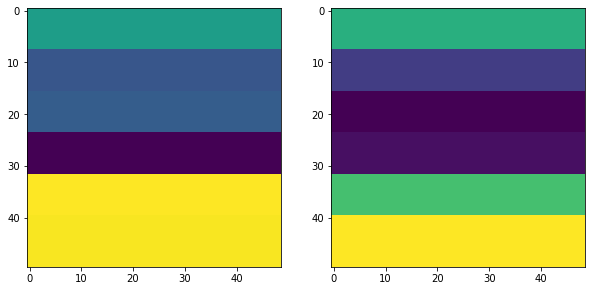

In [8]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(earth[3,:,:,0],cmap='viridis', aspect=1)
ax2.imshow(earth[3,:,:,1],cmap='viridis', aspect=1);

#### create 10 impedance models from the above earht models by multiplying Vp and Rho (last axis), display a few

In [9]:
impedances = [np.apply_along_axis(np.product, -1, e).astype(float) for e in earth]# Python 2
print (np.shape(impedances))

(10, 50, 49)


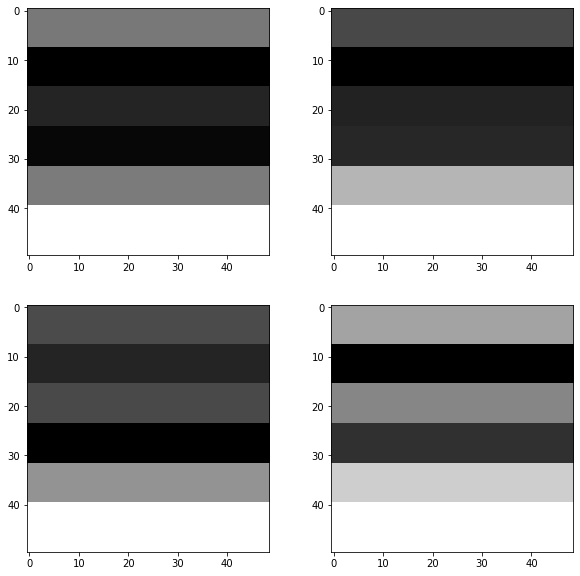

In [10]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(impedances[2],cmap='gray', aspect=1)
ax2.imshow(impedances[4],cmap='gray', aspect=1)
ax3.imshow(impedances[6],cmap='gray', aspect=1)
ax4.imshow(impedances[8],cmap='gray', aspect=1);

#### insert a vertical fault in the impedance models

In [11]:
faulted = copy.deepcopy(impedances)
for r, i in zip(faulted, np.arange(len(faulted))):
    temp = np.array(r)
    rolled = np.roll(np.array(r[:,:24]), 4, axis = 0)
    temp[:,:24]=rolled
    faulted[i]=temp
    
print (np.shape(faulted))

(10, 50, 49)


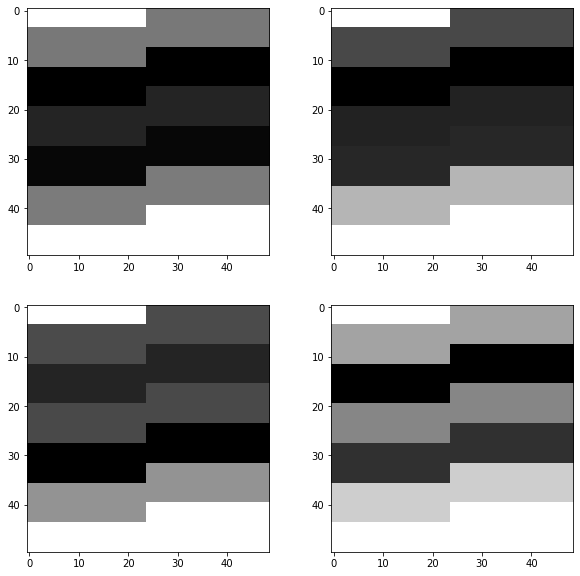

In [12]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(faulted[2],cmap='gray', aspect=1)
ax2.imshow(faulted[4],cmap='gray', aspect=1)
ax3.imshow(faulted[6],cmap='gray', aspect=1)
ax4.imshow(faulted[8],cmap='gray', aspect=1);

#### generate 10 reflection coefficient models and display a few

In [13]:
rc =  [(flt[1:,:] - flt[:-1,:]) / (flt[1:,:] + flt[:-1,:]) for flt in faulted]
print (np.shape(rc))

(10, 49, 49)


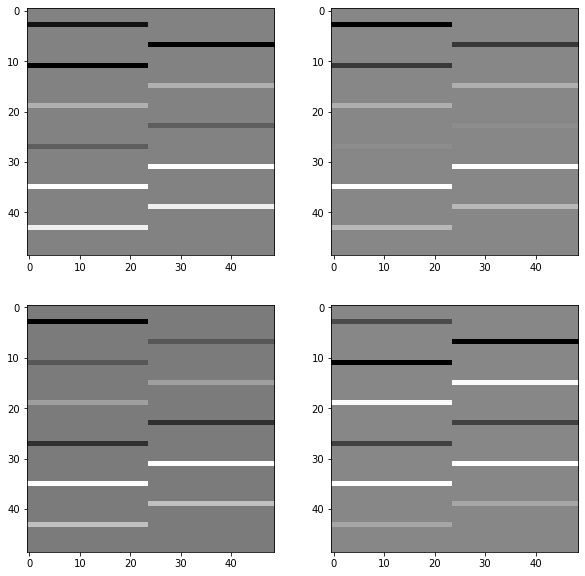

In [14]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(rc[2],cmap='gray', aspect=1)
ax2.imshow(rc[4],cmap='gray', aspect=1)
ax3.imshow(rc[6],cmap='gray', aspect=1)
ax4.imshow(rc[8],cmap='gray', aspect=1);

#### make 10 ricker wavelets

In [15]:
ws = []
ws = [bruges.filters.ricker(duration=0.098, dt=0.002, f=fr) 
      for fr in [35, 40, 45, 50, 55, 60, 65, 70, 75, 80]]

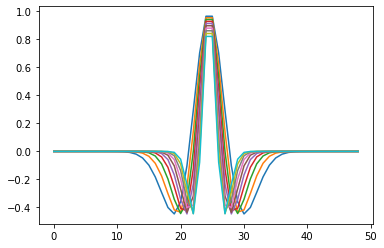

In [16]:
[plt.plot(w) for w in ws];

#### create array with synthetic models (10 faulted rc models x 10 wavelets), display a couple

In [17]:
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0,
                             arr=r) for r in rc for w in ws ]) # this way sorted by rc primary
                                                                     # e.g.:
                                                                     # 1st is:  rc 0, w0,   then 
                                                                     # 2nd is:  rc 1, w0,   and so on
                                                                     # and:
                                                                     # 1st is:  rc 0, w0    then 
                                                                     # 10th is: rc 0, w1,   and so on

print (np.shape(synth))

(100, 49, 49)


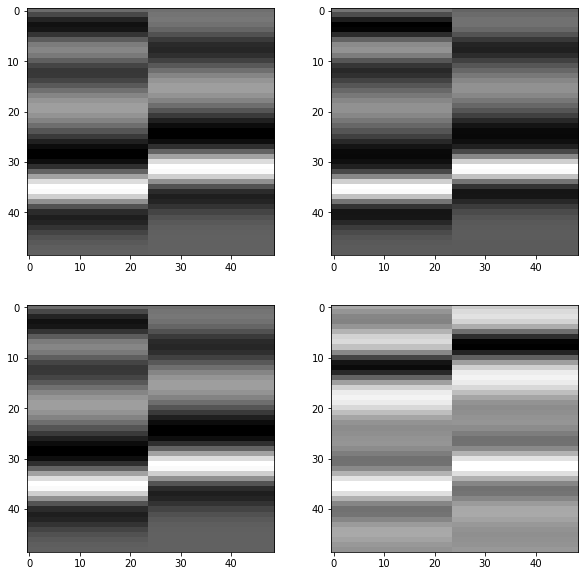

In [18]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(synth[0],cmap='gray', aspect=1)
ax2.imshow(synth[1],cmap='gray', aspect=1)
ax3.imshow(synth[0],cmap='gray', aspect=1)
ax4.imshow(synth[10],cmap='gray', aspect=1);

#### adding a bit of blur and some random noise, display again

In [19]:
blurred = sp.ndimage.gaussian_filter(synth, sigma=1.1)
noisy = blurred + 0.5 * blurred.std() * np.random.random(blurred.shape)
print (np.shape(noisy))

(100, 49, 49)


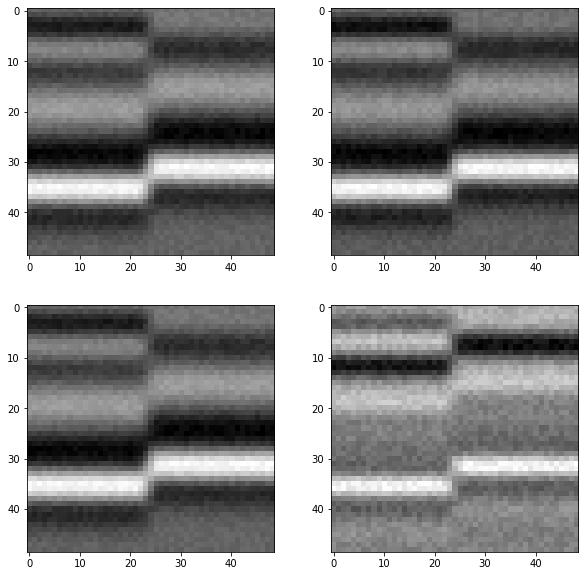

In [20]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

ax1.imshow(noisy[0],cmap='gray', aspect=1)
ax2.imshow(noisy[1],cmap='gray', aspect=1)
ax3.imshow(noisy[0],cmap='gray', aspect=1)
ax4.imshow(noisy[10],cmap='gray', aspect=1);